In [1]:
import galarp as grp
grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gala.units import galactic

from gala import potential as gp

from scipy import stats
from scipy.interpolate import interp1d

from matplotlib import animation

In [2]:
test = gp.MilkyWayPotential()
print(test.parameters)

for key in test.parameters.keys():
    print(key, test.parameters[key], test[key])


{'disk': {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>}, 'bulge': {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>}, 'nucleus': {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>}, 'halo': {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>}}
disk {'m': <Quantity 6.8e+10 solMass>, 'a': <Quantity 3. kpc>, 'b': <Quantity 0.28 kpc>} MiyamotoNagaiPotential
bulge {'m': <Quantity 5.e+09 solMass>, 'c': <Quantity 1. kpc>} HernquistPotential
nucleus {'m': <Quantity 1.71e+09 solMass>, 'c': <Quantity 0.07 kpc>} HernquistPotential
halo {'m': <Quantity 5.4e+11 solMass>, 'r_s': <Quantity 15.62 kpc>, 'a': <Quantity 1.>, 'b': <Quantity 1.>, 'c': <Quantity 1.>} NFWPotential


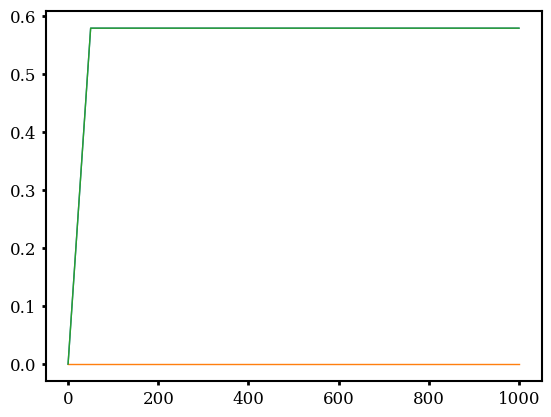

In [5]:

wind = grp.builtins.RB2006_Wind(inc=45, peak=800)

times = np.linspace(0, 1000, 1000) * u.Myr

plt.plot(times, wind.evaluate_arr(times), label="Wind")

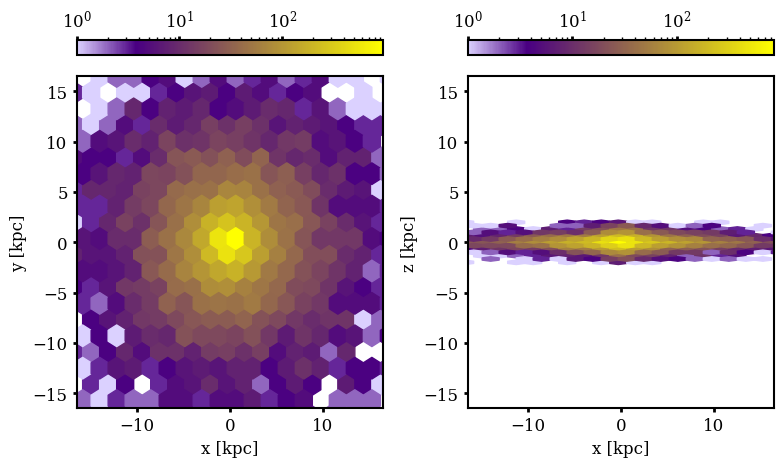

In [6]:
rb2006_satellite = grp.builtins.RB2006_Satellite()

mass_profile = grp.gen_mass_profile(rb2006_satellite)

# positions = grp.generate_exponential_positions(10000, 
#                                                h_R = rb2006_satellite["gas"].parameters["a"], 
#                                                h_z = rb2006_satellite["gas"].parameters["b"],
#                                                Rmax= rb2006_satellite["gas"].parameters["a"] * 4,

#                                                outname="temp/positions_RB.npy")

particles = grp.ExponentialGrid(h_R=rb2006_satellite["gas"].parameters["a"],
                                h_z=rb2006_satellite["gas"].parameters["b"],
                                n_particles=10000)

particles.generate(mass_profile=mass_profile, positions="temp/positions_RB.npy")

particles.plot_density(cmap=cmap, gridsize=30)

In [7]:

rb2006_wind = grp.builtins.RB2006_Wind()
shadow = grp.UniformExponentialZVariableShadow(damping = 0.3, R_disk=rb2006_satellite["gas"].parameters["a"], dynamic=True, z_dropoff=40)

sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)
orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)


# grp.animated_hexbin_plot(orbits, outname=f"figures/animated/RB_dup.gif")

 20%|██        | 81/399 [00:01<00:06, 48.63it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:44: RuntimeWarning: overflow encountered in square
  v_perp**2
/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:14: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/galarp/galarp/shadows.py:360: RuntimeWarning: overflow encountered in square
  dist = np.sqrt((x - cent) ** 2 + y**2)
 22%|██▏       | 86/399 [00:01<00:06, 48.18it/s]/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [00:07<00:00, 51.50it/s]


In [ ]:
def better_stripped(orbits):
    x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)
    vr = (x*vx + y*vy + z*vz) / r

    vr[vr > 5000] = 5000
    vr[np.isinf(vr)] = 5000
    vr[np.isnan(vr)] = 5000

    r[r > 1000] = 1000
    r[np.any([np.isinf(vr), np.isnan(vr)])] = 1000

    pot = orbits.metadata["POTENTIAL"]

    stripped = vr > np.sqrt(2 * np.abs(pot.energy(np.array([x, y, z])))).to(u.km/u.s).value
    stripped = stripped.T.astype(int)

    for i in range(len(stripped)):
        this_stripped = stripped[i]
        first_stripped = np.argmax(this_stripped)

        if first_stripped == 0:
            continue
        stripped[i, first_stripped:] = 1
    return stripped

In [8]:
incs = np.linspace(0, 85, 10).astype(int)
# incs = [45]

rstrip_times = []
rstrips = []

for inc in incs:

    rb2006_wind = grp.builtins.RB2006_Wind(inc=inc)
    if inc < 10:
        shadow = grp.EdgeOnShadow(damping=0.8, R_disk=rb2006_satellite["gas"].parameters["a"],
                                  Z_disk=rb2006_satellite["gas"].parameters["b"], dynamic=True, z_dropoff=40)
    else:
        shadow = grp.UniformExponentialZVariableShadow(damping = 0.8, R_disk=rb2006_satellite["gas"].parameters["a"], 
                                                       dynamic=True, z_dropoff=40)
    shadow.init_from_wind(rb2006_wind)

    sim = grp.RPSim(wind=rb2006_wind, potential=rb2006_satellite, shadow=shadow, rho_icm=1e-26 * u.g/u.cm**3)
    orbits = sim.run(particles, integration_time=2000 * u.Myr, dt=5*u.Myr, printout=False, rho_icm=1e-26 * u.g/u.cm**3)


    times, rstrip_curve = grp.rstrip(orbits)
    rstrip_times.append(times)
    rstrips.append(rstrip_curve)

    # grp.animated_hexbin_plot(orbits, outname=f"figures/rb_dup/animated/animated_hexbin_{inc}.gif", 
    #                          n_frames=200, cmap=cmap, xextent=20, 
    #                          vextent=(-100, 200))
    
    # grp.k3d_plot([orbits], outname=f"figures/rb_dup/k3d/k3d_plot_{inc}.html")


 16%|█▌        | 63/399 [00:01<00:06, 50.99it/s]/Users/hsouchereau/galarp/galarp/rampressure.py:44: RuntimeWarning: overflow encountered in square
  v_perp**2
 17%|█▋        | 69/399 [00:01<00:06, 51.19it/s]/Users/hsouchereau/galarp/galarp/postprocessing/analysis/disk_analysis.py:14: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/Users/hsouchereau/galarp/galarp/shadows.py:283: RuntimeWarning: overflow encountered in square
  in_ellipsoid = (y / self.R_disk) ** 2 + (z / self.Z_disk) ** 2 < 1
 19%|█▉        | 75/399 [00:01<00:06, 51.21it/s]/Users/hsouchereau/gala/gala/integrate/pyintegrators/rk5.py:79: RuntimeWarning: invalid value encountered in multiply
  dw = dw + C[i]*K[i]
100%|██████████| 399/399 [00:07<00:00, 53.88it/s]
/Users/hsouchereau/anaconda3/envs/jelly/lib/python3.9/site-packages/astropy/units/core.py:1103: RuntimeWarning: overflow encountered in multiply
  return lambda val: scale * _condition_arg(val)
/Users/hsouchereau/galarp/galarp/post

  0%|          | 0/399 [00:00<?, ?it/s]/Users/hsouchereau/galarp/galarp/shadows.py:14: RuntimeWarning: divide by zero encountered in divide
  return z / np.tan(phi)
 13%|█▎        | 50/399 [00:01<00:07, 45.38it/s]/Users/hsouchereau/galarp/galarp/shadows.py:360: RuntimeWarning: overflow encountered in square
  dist = np.sqrt((x - cent) ** 2 + y**2)
100%|██████████| 399/399 [00:07<00:00, 54.00it/s]


100%|██████████| 399/399 [00:07<00:00, 53.16it/s]


 26%|██▋       | 105/399 [00:02<00:06, 47.85it/s]


KeyboardInterrupt: 

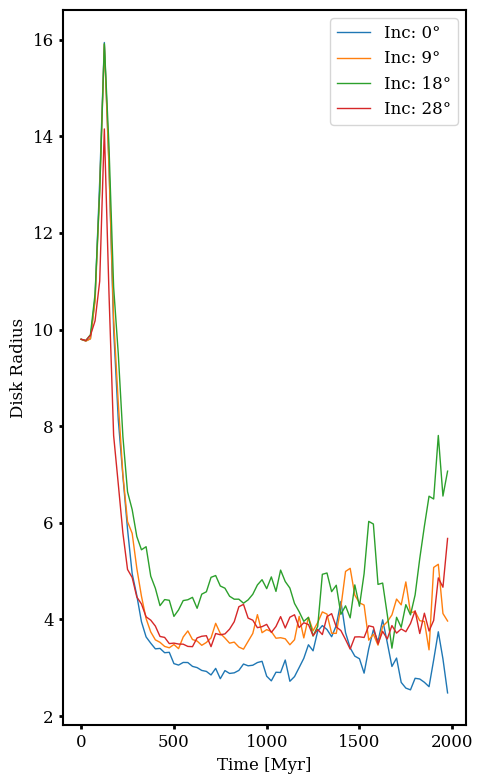

In [9]:
fig = plt.figure(figsize=(5, 8))


for i in range(len(rstrips)):
    time = rstrip_times[i]
    curve = rstrips[i]
    
    plt.plot(time, curve, label=f"Inc: {incs[i]}°")

plt.xlabel("Time [Myr]")
plt.ylabel("Disk Radius")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:

# grp.r_vr(orbits, outname = "figures/animated/r_vr_RB.gif")

/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_3946/537201497.py:35: RuntimeWarning: overflow encountered in square
  r = np.sqrt(x**2 + y**2 + z**2)
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_3946/537201497.py:36: RuntimeWarning: overflow encountered in multiply
  vr = (x*vx + y*vy + z*vz) / r
/var/folders/gy/19m5w8qn3k10k6z5fvjf7byh0000gq/T/ipykernel_3946/537201497.py:36: RuntimeWarning: invalid value encountered in divide
  vr = (x*vx + y*vy + z*vz) / r


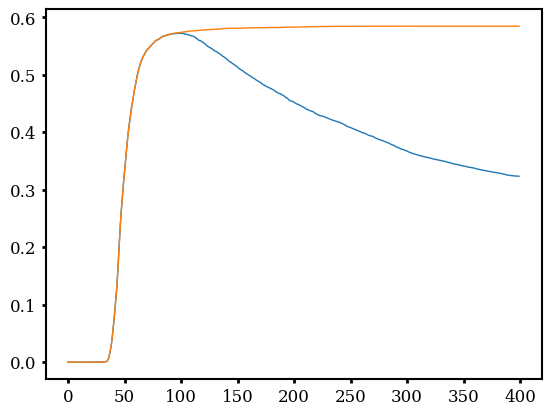

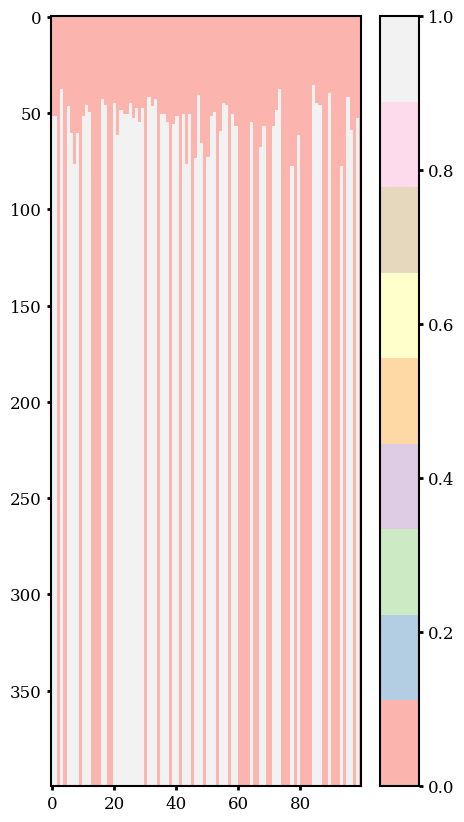

In [ ]:
def better_stripped(orbits):
    x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)
    vr = (x*vx + y*vy + z*vz) / r

    vr[vr > 5000] = 5000
    vr[np.isinf(vr)] = 5000
    vr[np.isnan(vr)] = 5000

    r[r > 1000] = 1000
    r[np.any([np.isinf(vr), np.isnan(vr)])] = 1000

    pot = orbits.metadata["POTENTIAL"]

    stripped = vr > np.sqrt(2 * np.abs(pot.energy(np.array([x, y, z])))).to(u.km/u.s).value
    stripped = stripped.T.astype(int)

    for i in range(len(stripped)):
        this_stripped = stripped[i]
        first_stripped = np.argmax(this_stripped)

        if first_stripped == 0:
            continue
        stripped[i, first_stripped:] = 1
    return stripped


def stripped_debugging(orbits, **kwargs):
    frames = kwargs.get("frames", 200)
    outname = kwargs.get("outname", "r_vr.gif")

    x,y,z, vx, vy, vz = grp.get_orbit_data(orbits.data, transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)
    vr = (x*vx + y*vy + z*vz) / r

    vr[vr > 5000] = 5000
    vr[np.isinf(vr)] = 5000
    vr[np.isnan(vr)] = 5000

    r[r > 1000] = 1000
    r[np.any([np.isinf(vr), np.isnan(vr)])] = 1000

    pot = orbits.metadata["POTENTIAL"]

    stripped = vr > np.sqrt(2 * np.abs(pot.energy(np.array([x, y, z])))).to(u.km/u.s).value
    stripped = stripped.T.astype(int)

    plt.plot(np.sum(stripped / len(stripped), axis=0))

    for i in range(len(stripped)):
        this_stripped = stripped[i]
        first_stripped = np.argmax(this_stripped)

        if first_stripped == 0:
            continue
        stripped[i, first_stripped:] = 1


        
    plt.plot(np.sum(stripped / len(stripped), axis=0))
    
    
    plt.figure(figsize=(5, 10))
    plt.imshow(stripped[0:100, :].astype(int).T, cmap="Pastel1", aspect="auto", interpolation="nearest")
    plt.colorbar(orientation="vertical", location="right")
    plt.savefig("figures/stripped_vs_time.png")

stripped_debugging(orbits)